オリジナル作成:　2011/06/04

<html id="* 第3章-エビデンス近似をSageで試す">
	<author>Hiroshi TAKEMOTO</author>
	(<email>take.pwave@gmail.com</email>)
	
	<h1>第3章-エビデンス近似をSageで試す</h1>
	<p>
		<a href="https://github.com/take-pwave/notebook/blob/master/PRML/01-Liear_Regression.ipynb">第1章-Sageを使って線形回帰を試してみる</a>では、
		与えられたモデルパラメータM, α、βに対して解いていましたが、
		実際には自分でベストなモデルパラメータM, α、βを求める必要があります。
		
		<a href="http://www.amazon.co.jp/dp/443110013X/">パターン認識と機械学習</a>
		の３章ではエビデンス関数を使って最適なパラメータを求める方法が説明されています。
	</p>	
	<p>
		ここでは、Sageを使ってエビデンス関数の評価、最適なモデルパラメータの推定を試してみます。
	</p>
</html>

<html id="** エビデンス関数の評価">
	<h2>エビデンス関数の評価</h2>
	<p>
		エビデンス関数の対数表現は、式(3.86)
$$
		\ln p(t|\alpha, \beta) =  \frac{M}{2} \ln \alpha + \frac{N}{2} \ln \beta -E(m_N) - \frac{1}{2} \ln | A | + \frac{N}{2} \ln (2 \pi)
$$
		で与えられます。
	</p>
	<p>
		ここで、$E(m_N)$は、式(3.82)
$$
		E(m_N) = \frac{\beta}{2}|| t = \Phi m_N ||^2 + \frac{\alpha}{2} m_N^T m_N
$$
		$m_N$は、式(3.84)
$$
		m_N = \beta A^{-1} \Phi^T t
$$
		Aは、式(3.81)
$$
		A = \alpha I + \beta \Phi^T \Phi
$$
	</p>
	<p>
		目指すは、図3.14です。		
	</p>
	<p align="center">
		<img src="images/04/Figure3.14.png" width="50%"></img>
	</p>
</html>

<html id="*** 準備">
	<h3>準備</h3>
	<p>
		<a href="https://github.com/take-pwave/notebook/blob/master/PRML/01-Liear_Regression.ipynb">第1章-Sageを使って線形回帰を試してみる</a>
		で使ったデータと同じものを座標Xと目的値tにセットし、関数Φを定義します。
	</p>
</html>

In [1]:
# PRML fig.3.14の再現
# PRMLのsin曲線のデータ
data = matrix([
        [0.000000, 0.349486],
        [0.111111, 0.830839],
        [0.222222, 1.007332],
        [0.333333, 0.971507],
        [0.444444, 0.133066],
        [0.555556, 0.166823],
        [0.666667, -0.848307],
        [0.777778, -0.445686],
        [0.888889, -0.563567],
        [1.000000, 0.261502],
        ]);
X = data.column(0)
t = data.column(1)
# データを増やす場合
# N = 25
# X = vector([random() for i in range(25)])
# t = vector([(sin(2*pi*x) + +gauss(0, 0.2)).n() for x in X.list()])

In [2]:
# Φ関数定義
def _phi(x, j):
    return x^j

<html id="*** エビデンスの計算">
	<h3>エビデンスの計算</h3>
	<p>
		まずは、α、βを固定値
		<ul>
			<li>$\alpha = 5 \times 10^{-3}$</li>
			<li>$\beta = 11.1$</li>
		</ul>
		として、多項式の次数をMを0から9まで変えた値を計算し、プロットしてみます。
	</p>
	<p>
		一番良いエビデンスは、M=4あたりになります。
		理由は分かりませんが、図3.14のようなM=3以降の急激な下降は見られません。
	</p>
</html>

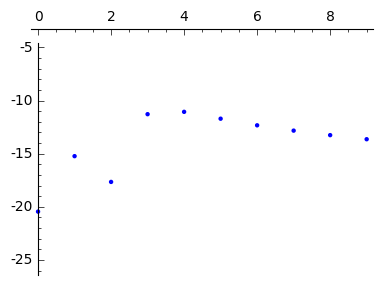

In [3]:
# α=5*10^-3, β=11.1を固定して計算すると
ln_p_List = []
N = len(t)
alpha = 5*10^-3
beta = 11.1
for M in range(10):
    Phi = matrix(RDF, [[ _phi(x,j) for j in range(0, (M+1))] for x in X.list()])
    Phi_t = Phi.transpose()
    # m_N, Aを定義
    A = alpha*matrix((M+1),(M+1),1) + beta*Phi_t * Phi
    m_N = beta*A.inverse() * Phi_t * t
    # エビデンスの対数
    res = (t - Phi*m_N)
    E_mN = beta/2* res * res + alpha/2 * m_N * m_N
    ln_p_t = M/2 * ln(alpha) + N/2 * ln(beta) - E_mN - 1/2 * ln(A.det()) - (N/2 * ln(2*pi))
    ln_p_List += [ln_p_t]
list_plot(ln_p_List, ymin = -26, ymax = -5).show(figsize=4)
# 結果は、M=3以降でfig.3.14のような急激な降下は見られない

<html id="*** β_MLを使ってエビデンスを計算">
	<h3>β_MLを使ってエビデンスを計算</h3>
	<p>
		そこで、βを平均値の分散$\beta_{ML}$を使って計算してみました。
$$
		\frac{1}{\beta_{ML}} = \frac{1}{N} \sum (y(x_n, W_ML) - t_n)^2 
$$
	</p>
	<p>
		期待に反し、M=0でも高い値となり、あまり良くありません。
	</p>
</html>

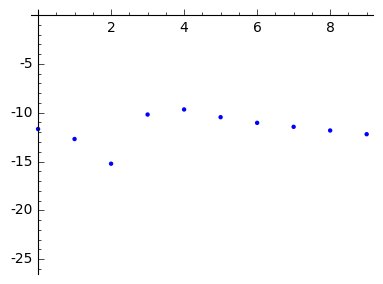

In [4]:
# 1/β_ML = 1/N Σ{y(x_n,W_ML) - t_n}^2から計算したβ_MLでエビデンスを計算
beta_ML_List = []
ln_p_List = []
for M in range(10):
    Phi = matrix(RDF, [[ _phi(x,j) for j in range(0, (M+1))] for x in X.list()]) 
    Phi_t = Phi.transpose()
    # m_N, Aを定義
    A = alpha*matrix((M+1),(M+1),1) + beta*Phi_t * Phi
    m_N = beta* A.inverse() * Phi_t* t 
    # エビデンスの対数
    res = (t - Phi*m_N)
    beta_ML = N / (res*res)
    E_mN = beta_ML/2* res * res + alpha/2 * m_N * m_N
    ln_p_t = M/2 * ln(alpha) + N/2 * ln(beta_ML) - E_mN - 1/2 * ln(A.det()) - N/2 * ln(2*pi)
    ln_p_List += [ln_p_t]
    beta_ML_List += [beta_ML]
list_plot(ln_p_List, ymin = -26, ymax = 0).show(figsize=4)
#print beta_ML_List

<html id="*** どうして図3.14と合わないのか？">
	<h3>どうして図3.14と合わないのか？</h3>
	<p>
		どうして図3.14のような結果にならないのかと調べたのですが、他にも同様の計算をした
		方がいらして、私と同じ傾向になったとの記述がありました。
		<a href="http://d.hatena.ne.jp/n_shuyo/20090715/evidence">基底関数を色々変えて、線形回帰のエビデンスを計算してみた</a>
	</p>
	<p>
		私の推測では、ln |A|の計算をA.norm()と間違えたのではないかと思われます。以下にA.norm()としたときの図を示します。
	</p>
</html>

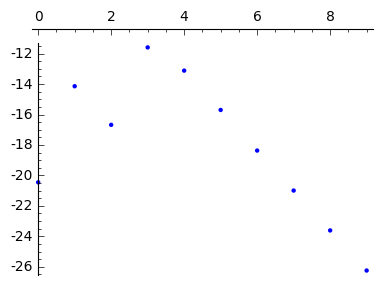

In [5]:
# 当初、式3.85, 3.86のミスプリと考えたのですが、
# →http://d.hatena.ne.jp/n_shuyo/20090715/evidence#c
#    n_shuyoさんのコメントで 正則行列の行列式は、逆行列の行列式の逆数：|A| = 1/|A^-1|
#    式3.85, 3.86 は正しい！
# 私の推測：図3.14の計算で ln |A|とするところをln A.norm()と間違えたのではないか
ln_p_List = []
for M in range(10):
    Phi = matrix(RDF, [[ _phi(x,j) for j in range(0, (M+1))] for x in X.list()]) 
    Phi_t = Phi.transpose()
    # m_N, Aを定義
    A = alpha*matrix((M+1),(M+1),1) + beta*Phi_t * Phi
    m_N = beta* A.inverse() * Phi_t* t 
    # エビデンスの対数
    res = (t - Phi*m_N)
    E_mN = beta/2* res * res + alpha/2 * m_N * m_N
    ln_p_t = M/2 * ln(alpha) + N/2 * ln(beta) - E_mN - 1/2 * ln(A.norm()) - N/2 * ln(2*pi)
    ln_p_List += [ln_p_t]
list_plot(ln_p_List, figsize=4)

<html id="*** 最適なα、βを求める">
	<h3>最適なα、βを求める</h3>
	<p>
		α、βを固定にした場合に、エビデンスが最大はM=4だったので、M=4に対する
		最適なα、βを求めてみます。
	</p>
	<p>
		エビデンスを最大にするαは、式(3.92)
$$
		\alpha = \frac{\gamma}{m_N^T m_N}
$$
		ここで$\gamma$は、式(3.87)
$$
		(\beta \Phi^T \Phi) u_i = \lambda_i u_i
$$
		の固有値から、式(3.91)
$$
		\gamma = \sum_{i} \frac{\lambda_i}{\alpha + \lambda_i}
$$
		で求まります。
	</p>
	<p>
		βについても、式(3.95)
$$
		\frac{1}{\beta} = \frac{1}{N - \gamma} \sum_{n=1}^{N} ( t_n - m_N^T \phi(x_n))^2
$$
	</p>
	<p>
		$\gamma$は、$\alpha$に依存し、$m_N$も$\alpha$に依存するため、すぐに最適な値を得ることが
		できません。
		
		<ol>
			<li>適当な $\alpha, \beta$を初期値とする</li>
			<li>$m_N$, $\gamma$を求め</li>
			<li>式(3.95)から$\beta$を求める</li>
			<li>式(3.92)から$\alpha$を求め、2番目からを繰り返す</li>
		</ol>
	</p>
	<p>
		以下の例では、
		<ul>
			<li>$\alpha = 5 \times 10^{-3}$</li>
			<li>$\beta = 11.1$</li>
		</ul>
		から20回の計算を繰り返し、$\gamma, \alpha, \beta$の値をプリントアウトしてみました。
	</p>
</html>

In [6]:
# M=4の場合のα、βを決める
M=4
Phi = matrix(RDF, [[ _phi(x,j) for j in range(0, (M+1))] for x in X.list()]) 
Phi_t = Phi.transpose()
# Φ^T Φは固定なので、先に固有値を計算
B = Phi_t*Phi
lambs = B.eigenvalues()
# 初期化
alpha = 5*10^(-3)
beta = 11.1
gamma = M
for i in range(20):
    A = alpha*matrix((M+1),(M+1),1) + beta*Phi_t * Phi
    m_N = beta* A.inverse() * Phi_t* t 
    gamma = sum((lamb*beta) /(alpha + (lamb*beta)) for lamb in lambs)
    alpha = gamma/(m_N*m_N)
    res = (t - Phi*m_N)
    beta = (N - gamma) / (res*res)
    print gamma, alpha, beta

4.02295319874 0.0160029572678 15.5703330431
3.86957616939 0.0192233025727 14.6079344569
3.81804019954 0.0208658867531 14.0162355337
3.79079625631 0.021876053777 13.6574090928
3.77410819657 0.0225480023858 13.4248103487
3.76308615077 0.0230152846069 13.2666278994
3.75546956914 0.0233495381967 13.1554382026
3.75004882783 0.0235932327887 13.0754487343
3.74611222743 0.0237732924978 13.0169432556
3.74321234677 0.0239076177514 12.973632867
3.7410540217 0.0240085312871 12.9412853436
3.73943541844 0.0240847392383 12.9169657574
3.7382147331 0.0241425141272 12.8985911035
3.73729026269 0.0241864427411 12.8846563016
3.73658790674 0.0242199173426 12.8740587014
3.73605302024 0.0242454685376 12.8659818046
3.73564493065 0.0242649966702 12.8598160009
3.73533314922 0.0242799360403 12.8551032449
3.73509469602 0.0242913734086 12.8514976848
3.73491217789 0.0243001346625 12.848737196


</html>

<html id="*** γと2αEw(mN)のグラフ">
	<h3>γと2αEw(mN)のグラフ</h3>
	<p>
		M=4の多項式回帰に対して、図3.16(a)
	</p>
	<p align="center">
		<img src="images/04/Figure3.16a.png" width="50%"></img>
	</p>
	<p>
		のように$\gammaと2\alpha E_w(m_N)$のグラフを$\ln \alpha$の関係を図化してみます。
	</p>
	<p>
		形が図3.16とは異なり、曲線の交差する点もα=0.024だとln αの値は負になるのに、図3.16は正の部分で
		交差しています。（何かちがう！）
	</p>
</html>

In [7]:
# γをln(a)の関数として定義
def g(ln_a):
    return abs(sum((lamb*beta) /(e^ln_a + (lamb*beta)) for lamb in lambs))
a_plt = plot(g, [x,-6, 6], color='red')

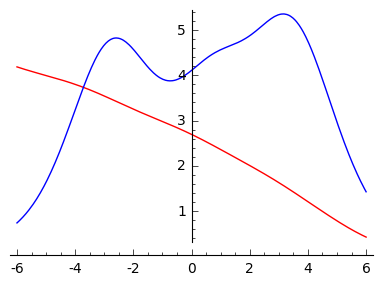

In [8]:
# 2αEw(m_N)をln(a)の関数として定義
def aEw(ln_a):
    a = (e^ln_a).n()
    A = a*matrix((M+1),(M+1),1) + beta*Phi_t * Phi
    m_N = beta* A.inverse() * Phi_t* t
    # m_Nいくつかの点が複素数になるためabs(a*m_N*m_N)とした
    return abs(a*m_N*m_N)
Ew_plt = plot(aEw, [x,-6, 6], color='blue')
(a_plt + Ew_plt).show(figsize=4)

<html id="*** 残差と対数エビデンスのグラフ">
	<h3>残差と対数エビデンスのグラフ</h3>
	<p>
		同様に、M=4の多項式回帰に対して、図3.16(b)
	</p>
	<p align="center">
		<img src="images/04/Figure3.16b.png" width="50%"/>
	</p>
	<p>
		のように残差と対数エビデンスを$\ln \alpha$の関係を図化してみます。
	</p>
	<p>
		やはり形が、図3.16とは異なります。
	</p>
</html>

In [9]:
b_phi_2 = beta*Phi_t*Phi
Phi_t_t = Phi_t* t
def ln_pt(ln_a):
    a = (e^ln_a).n()
    A = a*matrix(RDF, (M+1),(M+1),1) + b_phi_2
    m_N = beta* A.inverse() * Phi_t_t
    res = (t - Phi*m_N)
    E_mX = beta/2 * res*res + a/2 * m_N*m_N
    # E_mXいくつかの点が複素数になるためabs(E_mX)とした
    return (M/2 * ln_a + N/2 * ln(beta) - abs(E_mX) -1/2*ln(A.det()) - N/2*ln(2*pi)).n()
#
def res2(ln_a):
    a = (e^ln_a).n()
    A = a*matrix(RDF, (M+1),(M+1),1) + b_phi_2
    m_N = beta* A.inverse() * Phi_t_t
    res = (t - Phi*m_N)
    return abs(res*res)

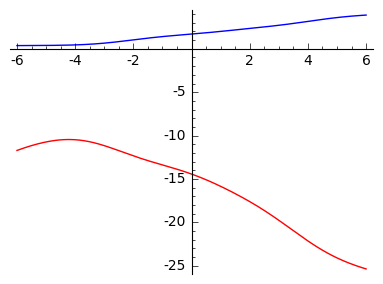

In [10]:
ln_pt_plt = plot(ln_pt, [x,-6, 6], color='red')
res_2_plt = plot(res2, [x,-6, 6])
(ln_pt_plt + res_2_plt).show(figsize=4)

<html id="*** M=4に対する最適な解">
	<h3>M=4に対する最適な解</h3>
	<p>
		M=4の多項式回帰に対する最適なα、βを使って$sin(2 \pi x)$、観測データ、フィッティング曲線、分散をグラフに表示してみます。
	</p>
</html>

In [11]:
# データのプロット
x = var('x')
sin_plt = plot(sin(2*pi*x),[x, 0, 1], rgbcolor='green')
data_plt = list_plot(zip(X, t))

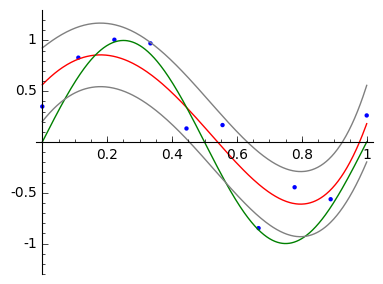

In [12]:
# 求まったα、βでベイズ的なフィッティングを再計算
alpha = 0.0243001346625 
beta = 12.848737196

Phi = matrix(RDF, [[ _phi(x,j) for j in range(0, (M+1))] for x in X.list()]) 
Phi_t = Phi.transpose()
# ムーア＿ベンローズの疑似逆行列
Phi_dag = (alpha*matrix((M+1),(M+1),1) + beta*Phi_t * Phi).inverse()*Phi_t;
# 平均の重み
Wml = beta*Phi_dag * t
f = lambda x : sum(Wml[i]*x^i for i in range(0, (M+1)))
# 分散
def s(x):
    phi_x = vector([x^i for i in range(M+1)])
    S = (alpha*matrix((M+1),(M+1),1) + beta*Phi_t * Phi).inverse()
    s_sqr = 1/beta + phi_x * S * phi_x
    return sqrt(s_sqr)
s_u_plt = plot(lambda x : f(x) + s(x), [x, 0, 1],  rgbcolor='grey')
s_d_plt = plot(lambda x : f(x) - s(x), [x, 0, 1],  rgbcolor='grey')
y_plt = plot(f, [x, 0, 1],  rgbcolor='red')
(y_plt + data_plt + sin_plt + s_u_plt + s_d_plt).show(ymin=-1.25, ymax=1.25, figsize=4)

<html>
	<p>
		M=9の最適解（図1.17）
	<p align="center">
		<img src="images/04/Figure1.17.png" width="50%"></img>
	</p>
		と比べると若干フィッティングが良くありませんが、与えられた点をスムーズに補完しているのがわかります。
	</p>
</html>

<html id="** どうしてエビデンス関数が合わないのか">
	<h2>どうしてエビデンス関数が合わないのか</h2>
	<p>
		つぎにどうして、図3.16と合わないのか、調べてみます。
	</p>
	<p>
		図3.16の説明をよく読むと、基底関数が多項式ではなく、ガウス基底関数になっていました。
	</p>
</html>

<html id="*** 基底関数のチェック">
	<h3>基底関数のチェック</h3>
	<p>
		ガウス基底関数がどのようなものなのか、図3.1を再現しながら、見てみましょう。
	</p>
	<p>
		以下に、
		<ul>
			<li>多項式の基底関数</li>
			<li>ガウス基底関数</li>
$$
			\phi_j(x) = exp \left \{ - \frac{(x - \mu_j)^2}{2 s^2} \right \}
$$
			<li>シグモイド基底関数</li>
$$
			\phi_j(x) = \sigma \left( \frac{x - \mu_j}{s} \right)
$$
$$
			\sigma(a) = \frac{1}{1 + exp(-a)}
$$
		</ul>
		を表示します。
	</p>
	<p>
		ガウス基底関数、シグモイド基底関数では、μの値として-1から1（問題によって0から1の場合もある）に
		とり、それを基底関数の数で等分した値をとるみたいです。
		<a href="http://d.hatena.ne.jp/smly/20100630/1277904761">線形回帰モデルとか</a>を参考にしました。
	</p>
</html>

In [13]:
# 基底関数のチェック
from pylab import linspace
M = 11
mu = linspace(-1, 1, M)
s = 0.1
s_sq = (s)^2
# 多項式基底関数定義
def _phi_poly(x, j):
    return x^j
    
# ガウス基底関数
def _phi_gauss(x, j):
    return e^(-1*(x - mu[j])^2/(2* s_sq))
    
# ロジスティック基底関数
def _logi_sig(x):
    return 1/(1 + e^(-1*x))
    
def _phi_sigmoid(x, j):
    return _logi_sig((x - mu[j])/s)

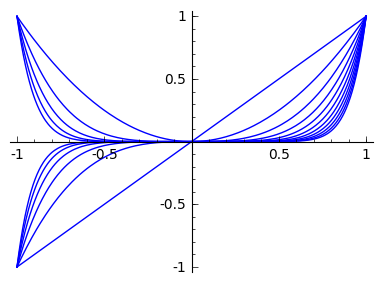

In [14]:
x = var('x')
poly_plt =Graphics()
for j in range(1, M+1):
    f = lambda x : _phi_poly(x, j)
    poly_plt += plot(f, [x, -1, 1])
poly_plt.show(figsize=4)

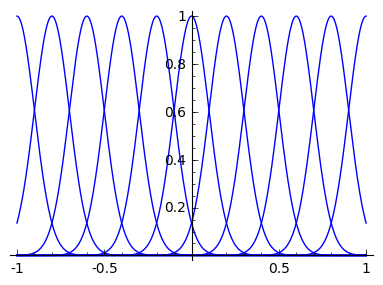

In [15]:
gauss_plt =Graphics()
for j in range(M):
    f = lambda x : _phi_gauss(x, j)
    gauss_plt += plot(f, [x, -1, 1])
gauss_plt.show(figsize=4)

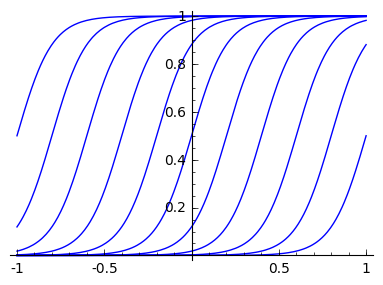

In [16]:
sigmoid_plt =Graphics()
for j in range(M):
    f = lambda x : _phi_sigmoid(x, j)
    sigmoid_plt += plot(f, [x, -1, 1])
sigmoid_plt.show(figsize=4)

<html id="*** ガウス基底関数を使ったγと2αEw(mN)のグラフ">
	<h3>ガウス基底関数を使ったγと2αEw(mN)のグラフ</h3>
	<p>
		M=9個のガウス基底関数を使ったγと2αEw(mN)のグラフを以下に示します。
	</p>
	<p>
		関数の形状と交差点の位置が図3.16と合います。
	</p>
</html>

In [17]:
# ガウス基底関数で三角関数の例題を近似
# j=0に対応するため_phiを以下のように定義
def _phi(x, j):
    if j == 0:
        return 1
    else:
        return _phi_gauss(x, j-1)

# 定数をセット
M=9
mu = linspace(0, 1, M)
Phi = matrix(RDF, [[ _phi(x,j) for j in range(0, (M+1))] for x in X.list()]) 
Phi_t = Phi.transpose()
# Φ^T Φは固定なので、先に固有値を計算
B = Phi_t*Phi
lambs = B.eigenvalues()
# 初期化
alpha = 5*10^(-3)
beta = 11.1
gamma = M
for i in range(20):
    A = alpha*matrix((M+1),(M+1),1) + beta*Phi_t * Phi
    m_N = beta* A.inverse() * Phi_t* t 
    gamma = sum((lamb*beta) /(alpha + (lamb*beta)) for lamb in lambs)
    alpha = gamma/(m_N*m_N)
    res = (t - Phi*m_N)
    beta = (N - gamma) / (res*res)
    print gamma, alpha, beta

8.97526712356 2.74314585233 3.30139118584
4.42110226407 6.39625703349 10.1314598003
4.79283709455 6.1963658677 10.6098731118
4.8967250477 6.15221412668 10.6952056914
4.9168569352 6.14416827636 10.7091975089
4.92032750261 6.14279733566 10.711525715
4.92091184724 6.14256697047 10.7119152912
4.92100983164 6.14252835527 10.7119805478
4.92102625056 6.14252188502 10.7119914807
4.92102900151 6.14252080095 10.7119933124
4.92102946241 6.14252061933 10.7119936193
4.92102953963 6.1425205889 10.7119936707
4.92102955257 6.1425205838 10.7119936793
4.92102955474 6.14252058294 10.7119936808
4.9210295551 6.1425205828 10.711993681
4.92102955516 6.14252058278 10.7119936811
4.92102955517 6.14252058277 10.7119936811
4.92102955518 6.14252058277 10.7119936811
4.92102955518 6.14252058277 10.7119936811
4.92102955518 6.14252058277 10.7119936811


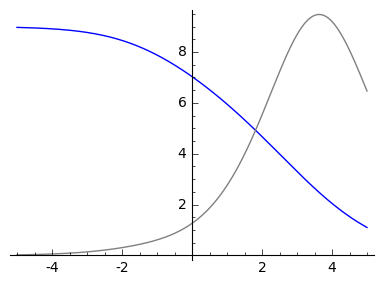

In [18]:
a_plt = plot(g, [x,-5, 5])
# 2αEw(m_N)をln(a)の関数として定義
def aEw(ln_a):
    a = (e^ln_a).n()
    A = a*matrix((M+1),(M+1),1) + beta*Phi_t * Phi
    m_N = beta* A.inverse() * Phi_t* t
    # m_Nいくつかの点が複素数になるためabs(a*m_N*m_N)とした
    return abs(a*m_N*m_N)
Ew_plt = plot(aEw, [x,-5, 5], color='gray')
(a_plt + Ew_plt).show(figsize=4)

<html id="*** ガウス基底関数を使った残差と対数エビデンスのグラフ">
	<h3>ガウス基底関数を使った残差と対数エビデンスのグラフ</h3>
	<p>
		同様に、ガウス基底関数を使った残差と対数エビデンスのグラフを示します。
	</p>
	<p>
		残差の形状がやや違いますが、残差の最低値の付近に対数エビデンスの最大値が位置する
		部分はほぼ合っています。
	</p>
</html>

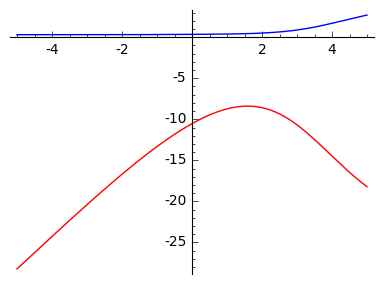

In [19]:
b_phi_2 = beta*Phi_t*Phi
Phi_t_t = Phi_t* t
def ln_pt(ln_a):
    a = (e^ln_a).n()
    A = a*matrix(RDF, (M+1),(M+1),1) + b_phi_2
    m_N = beta* A.inverse() * Phi_t_t
    res = (t - Phi*m_N)
    E_mX = beta/2 * res*res + a/2 * m_N*m_N
    return ((M/2 * ln_a + N/2 * ln(beta) - E_mX -1/2*ln(A.det()) - N/2*ln(2*pi))).n()
# 残差の定義
def res2(ln_a):
    a = (e^ln_a).n()
    A = a*matrix(RDF, (M+1),(M+1),1) + b_phi_2
    m_N = beta* A.inverse() * Phi_t_t
    res = (t - Phi*m_N)
    return abs(res*res)
# 結果のプロット
ln_pt_plt = plot(ln_pt, [x,-5, 5], color='red')
res_2_plt = plot(res2, [x,-5, 5])
(ln_pt_plt + res_2_plt).show(figsize=4)